In [53]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
from matplotlib import pyplot as plt
import os
from IPython.core.display import HTML
from IPython.display import Image
from datetime import datetime

### 0.1 HELPER FUNCTIONS


### 0.2 LOADING DATA

In [26]:

df_sales_raw = pd.read_csv('datasets\\train.csv',low_memory=False)
df_store_raw = pd.read_csv('datasets\\store.csv',low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [27]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.0 DESCRICAO DOS DADOS

In [28]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [29]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

### 1.2 Data Dimensions


In [30]:
print('Numeber of Rows: {}'.format(df1.shape[0]))
print('Numeber of Cols: {}'.format(df1.shape[1]))

Numeber of Rows: 1017209
Numeber of Cols: 18


### 1.3 Data Types

In [31]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.1 Check NA

In [32]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [33]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)# competition_open_since_month  

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year      
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year   
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval    
month_map = {1: 'Jan',2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

### 1.6 Change Types

In [34]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

### 1.7  Descriptive Statistical

In [35]:
num_attributes = df1.select_dtypes(include = ['float64','int64'])
cat_attributes = df1.select_dtypes(exclude = ['float64','int64','datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [37]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
#Dispercion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.min)).T
d2 = pd.DataFrame(num_attributes.apply(np.max)).T
d3 = pd.DataFrame(num_attributes.apply(np.std)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis)).T

m1 = pd.concat([d1,d2,d4,ct1,ct2,d3,d5,d6]).T.reset_index()
m1.columns = ['attributes','min','max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


C:\Users\Heithor\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

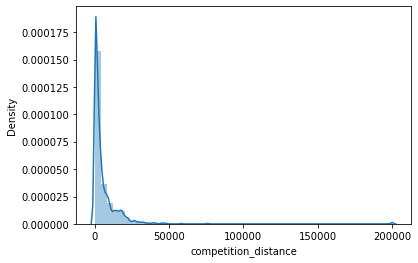

In [38]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [39]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

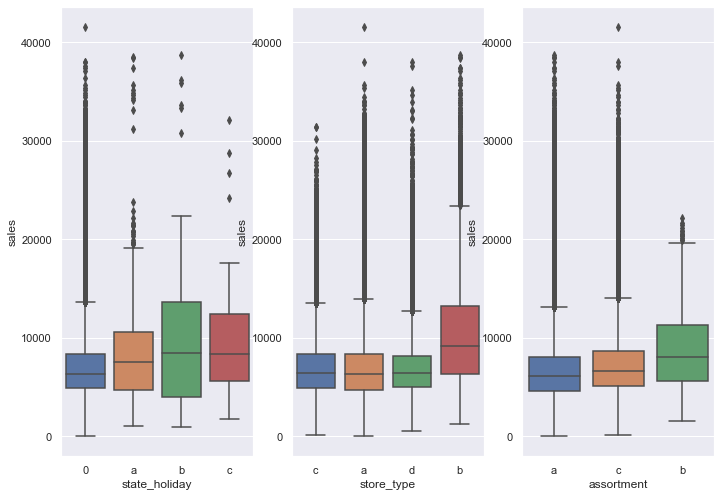

In [41]:
aux1= df1[(df1['state_holiday'] !=0) & (df1['sales']>0)]
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

## 2.0. PASSO 02 - FEATURE ENGINEERING


In [47]:
df2 = df1.copy()

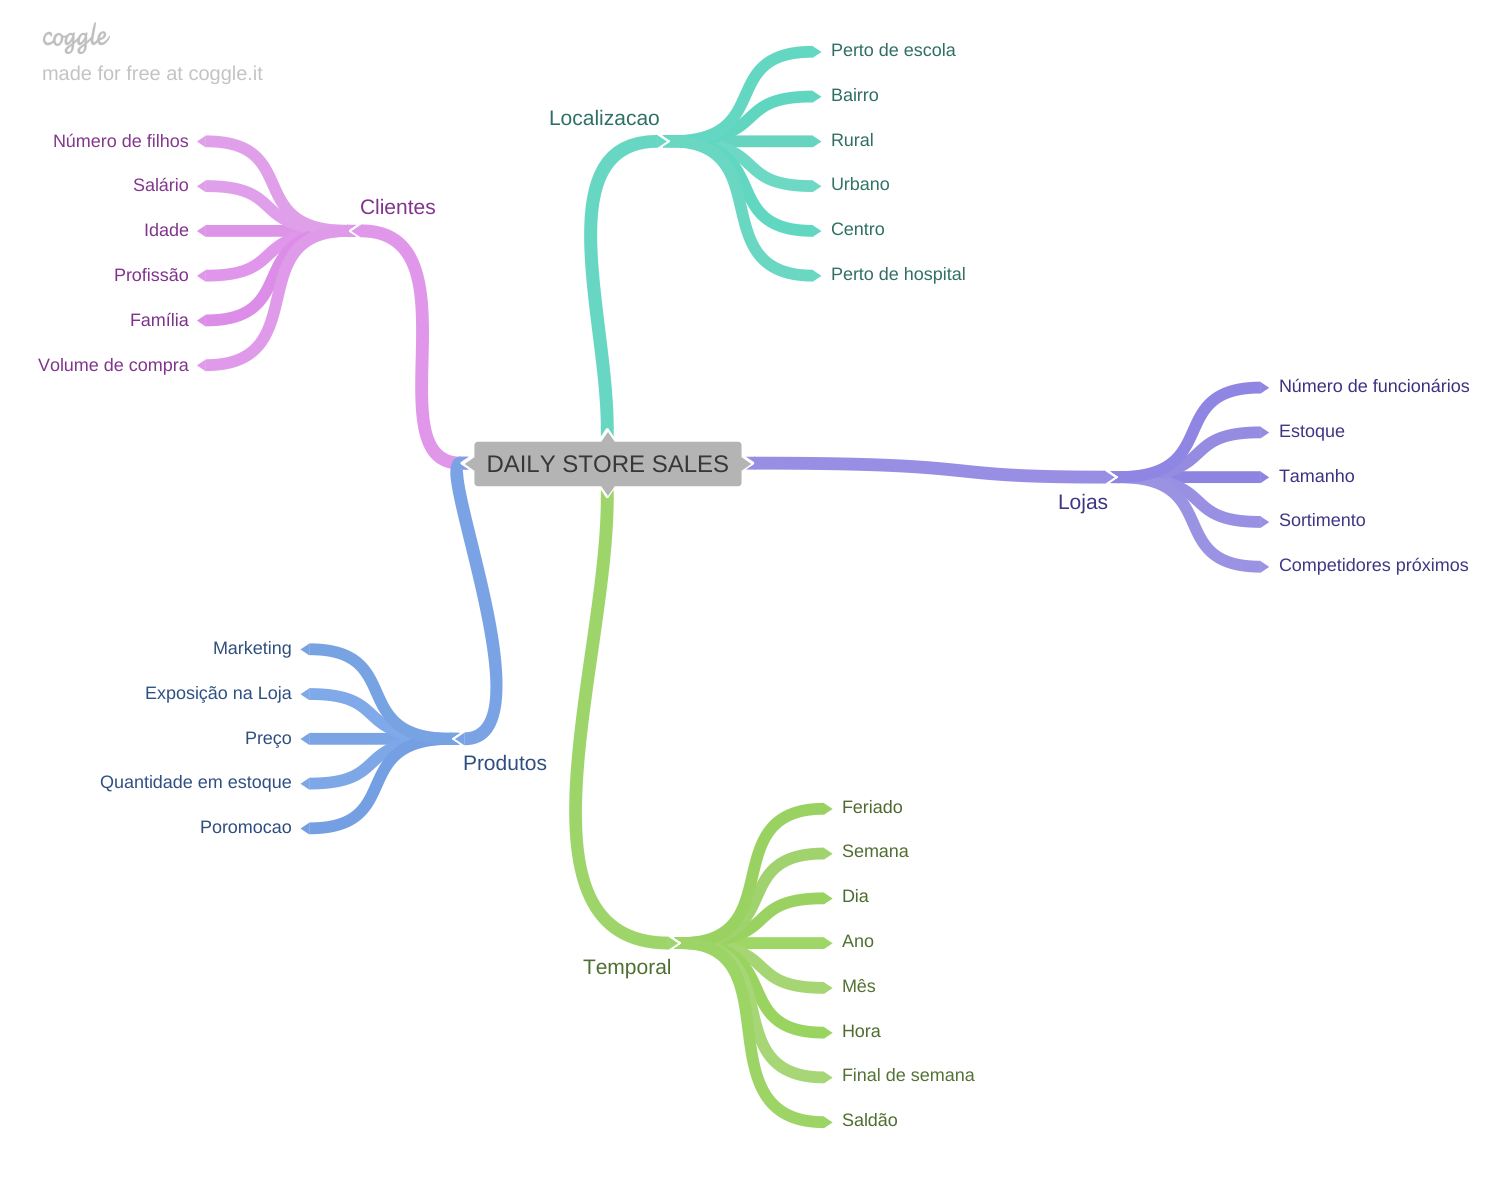

In [45]:
Image('img//mindmap_hyposis.png')

### 2.1. Criação das Hipóteses 

### 2.1.1. Hipóteses Loja


**1. Lojas com número maior de funcionários deveriam vender mais.**

**2. Lojas com maior capacidade de estoque deveriam vender mais.**

**3. Lojas com maior porte deveriam vender mais.**

**4. Lojas com maior sortimentos deveriam vender mais.**

**5. Lojas com competidores mais próximos deveriam vender menos.**

**6. Lojas com competidores à mais tempo deveriam vendem mais.**


### 2.1.2. Hipóteses Produto


**1. Lojas que investem mais em Marketing deveriam vender mais.**

**2. Lojas com maior exposição de produto deveriam vender mais.**

**3. Lojas com produtos com preço menor deveriam vender mais.**

**5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.**

**6. Lojas com promoções ativas por mais tempo deveriam vender mais.**

**7. Lojas com mais dias de promoção deveriam vender mais.**

**8. Lojas com mais promoções consecutivas deveriam vender mais.**


### 2.1.3. Hipóteses Tempo



**1. Lojas abertas durante o feriado de Natal deveriam vender mais.**

**2. Lojas deveriam vender mais ao longo dos anos.**

**3. Lojas deveriam vender mais no segundo semestre do ano.**

**4. Lojas deveriam vender mais depois do dia 10 de cada mês.**

**5. Lojas deveriam vender menos aos finais de semana.**

**6. Lojas deveriam vender menos durante os feriados escolares.**


## 2.2 Hipóteses Finais

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.



## 2.3 Feature Engineering

In [52]:
#year 
df2['year'] = df2['date'].dt.year

#month 
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#weer of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['week'] = df2['date'].dt.strftime('%Y-%W')


NameError: name 'datetime' is not defined

In [56]:
#competion since
df2['competition_since']= df2.apply(lambda x: datetime.datetime
                                    (year=x['competition_open_since_year'],
                                     month=x['competition_open_since_month'],
                                     day=1, ), axis=1)

#promo since

#assortment
#state holiday

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [51]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
